
<h1 style="text-align: center; font-size: 40px;">Answers Coding Exercise Module 2</h1><br>
<h3 style="text-align: center; font-size: 20px;">This notebook contains the answers for the coding exercise in Module 2 of the 2025 course "Causal Inference with Linear Regression: A Modern Approach" by CausAI. </h3><br><br><br>

Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import itertools
import random

import statsmodels.api as sm
from scipy import stats

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

<br><br> Question 1

In [2]:
data = pd.read_csv('EV_Miles.csv')
data

,age,gender,urban_rural,last_year_income,gas_price,owns_ev,miles_driven,fixed_expenses
0,62,0,0,68469.13,2.97,0,11114,24229.50
1,43,1,0,108212.95,2.88,1,14432,23737.42
2,63,1,0,70245.48,3.08,0,14152,10602.99
3,48,0,0,72165.09,2.98,0,12461,14083.11
4,47,1,0,49918.35,3.19,0,11246,22264.88
...,...,...,...,...,...,...,...,...
89858,55,1,0,110483.31,3.09,1,14239,22057.39
89859,68,1,0,88936.62,2.96,0,12715,16675.73
89860,43,1,0,98950.97,2.81,0,14419,26251.98
89861,42,0,0,102328.84,3.06,1,11868,27382.49


<br><br> Question 2

In [3]:
print("\n--- Shape of Dataset ---")
print(data.shape)

print("\n--- Columns & Data Types ---")
print(data.dtypes)

print("\n--- Unique Values Per Column ---")
for col in data.columns:
    print(f"{col}: {data[col].nunique()} unique values")

data.describe(include="all")


--- Shape of Dataset ---
(89863, 8)

--- Columns & Data Types ---
age                   int64
gender                int64
urban_rural           int64
last_year_income    float64
gas_price           float64
owns_ev               int64
miles_driven          int64
fixed_expenses      float64
dtype: object

--- Unique Values Per Column ---
age: 47 unique values
gender: 2 unique values
urban_rural: 2 unique values
last_year_income: 89282 unique values
gas_price: 95 unique values
owns_ev: 2 unique values
miles_driven: 7045 unique values
fixed_expenses: 87985 unique values


,age,gender,urban_rural,last_year_income,gas_price,owns_ev,miles_driven,fixed_expenses
count,89863.000000,89863.000000,89863.00000,89863.000000,89863.000000,89863.000000,89863.000000,89863.000000
mean,42.196432,0.496879,0.24899,81093.812888,3.000364,0.418526,13179.883322,20333.929052
std,10.143660,0.499993,0.43243,19698.653565,0.114016,0.493320,1352.073811,6279.246484
min,24.000000,0.000000,0.00000,31114.510000,2.500000,0.000000,9449.000000,5402.930000
25%,34.000000,0.000000,0.00000,66862.575000,2.920000,0.000000,12238.000000,15778.330000
50%,42.000000,0.000000,0.00000,78659.890000,3.000000,0.000000,13095.000000,19464.570000
75%,49.000000,1.000000,0.00000,92770.785000,3.080000,1.000000,14053.000000,23956.975000
max,70.000000,1.000000,1.00000,198228.430000,3.480000,1.000000,16926.000000,63361.360000


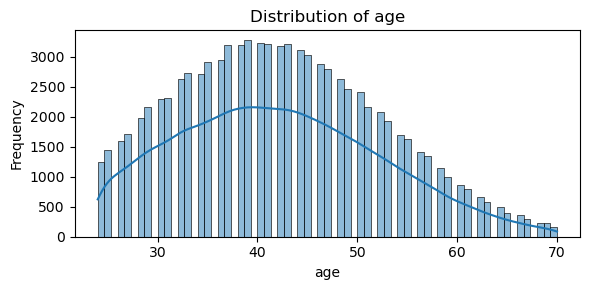

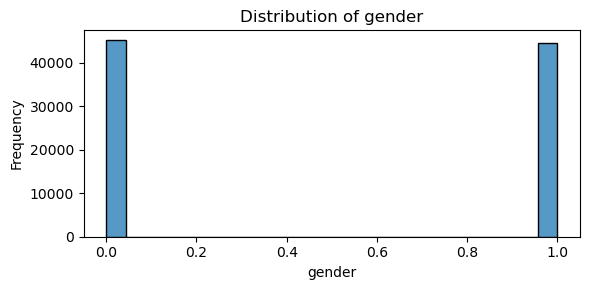

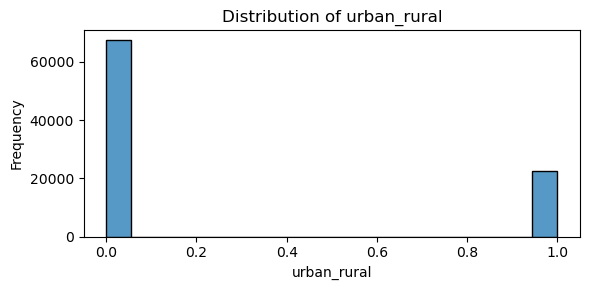

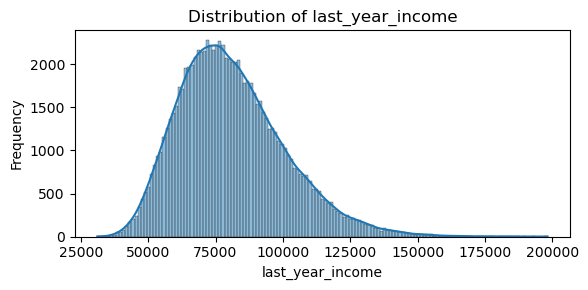

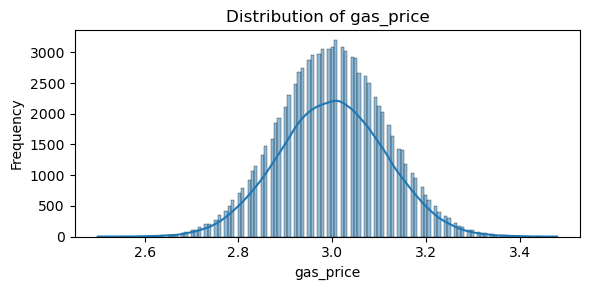

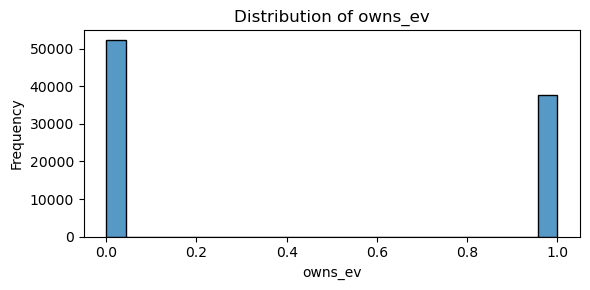

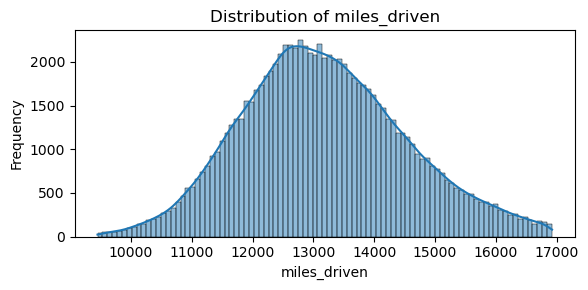

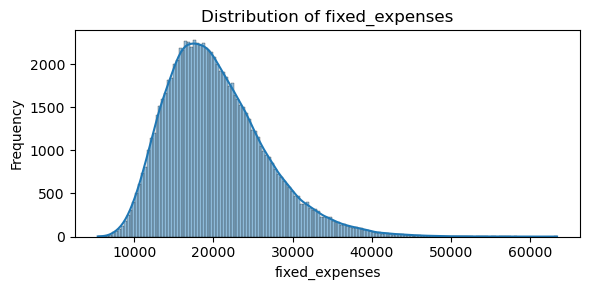

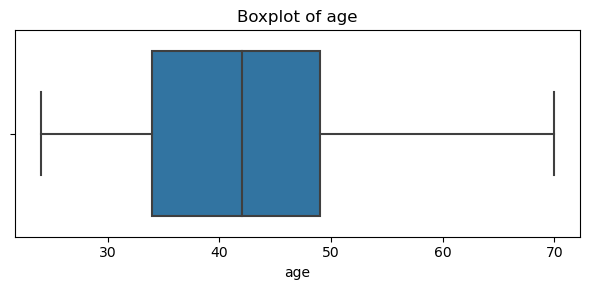

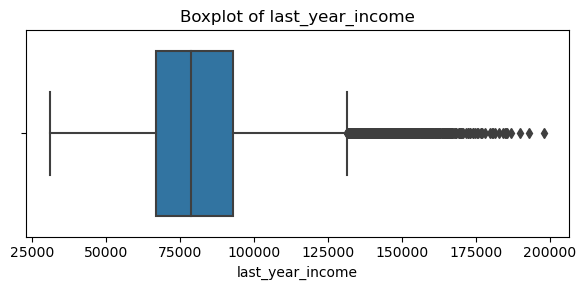

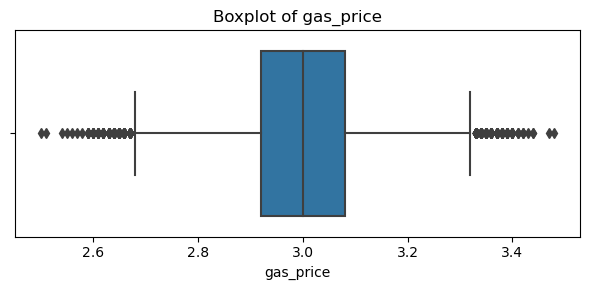

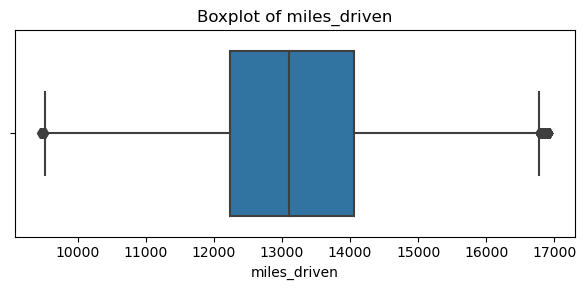

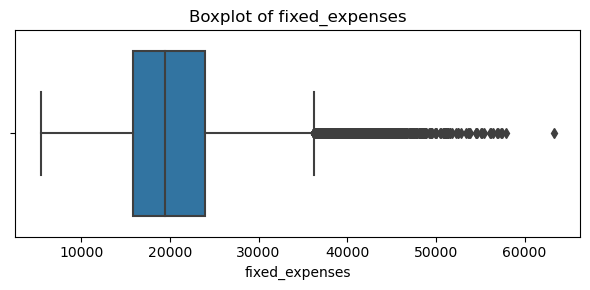

In [4]:
for col in data.columns:
    unique_vals = data[col].nunique(dropna=True)
    plt.figure(figsize=(6, 3))
    
    # Only show KDE if not binary
    sns.histplot(data[col], kde=(unique_vals > 2))
    
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

# Box plots to identify outliers (only for non-binary numeric columns)
non_binary_num_cols = [col for col in data.columns if data[col].nunique(dropna=True) > 2]

for col in non_binary_num_cols:
    plt.figure(figsize=(6, 3))
    sns.boxplot(x=data[col])
    plt.title(f'Boxplot of {col}')
    plt.xlabel(col)
    plt.tight_layout()
    plt.show()


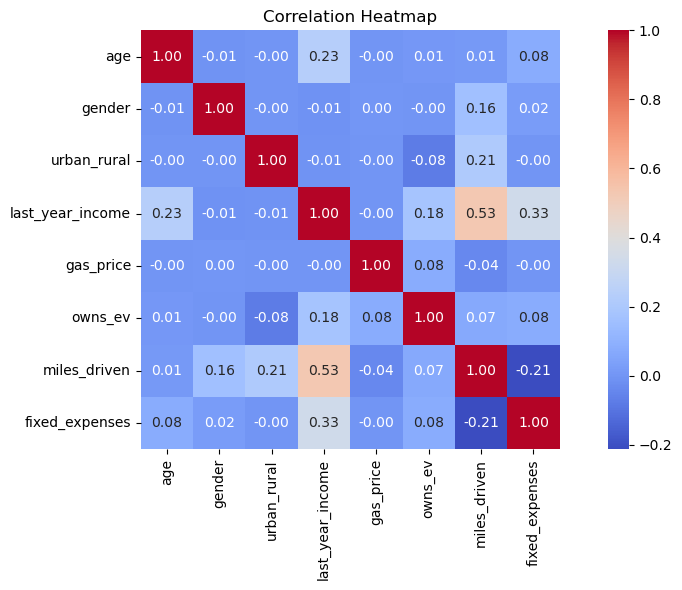

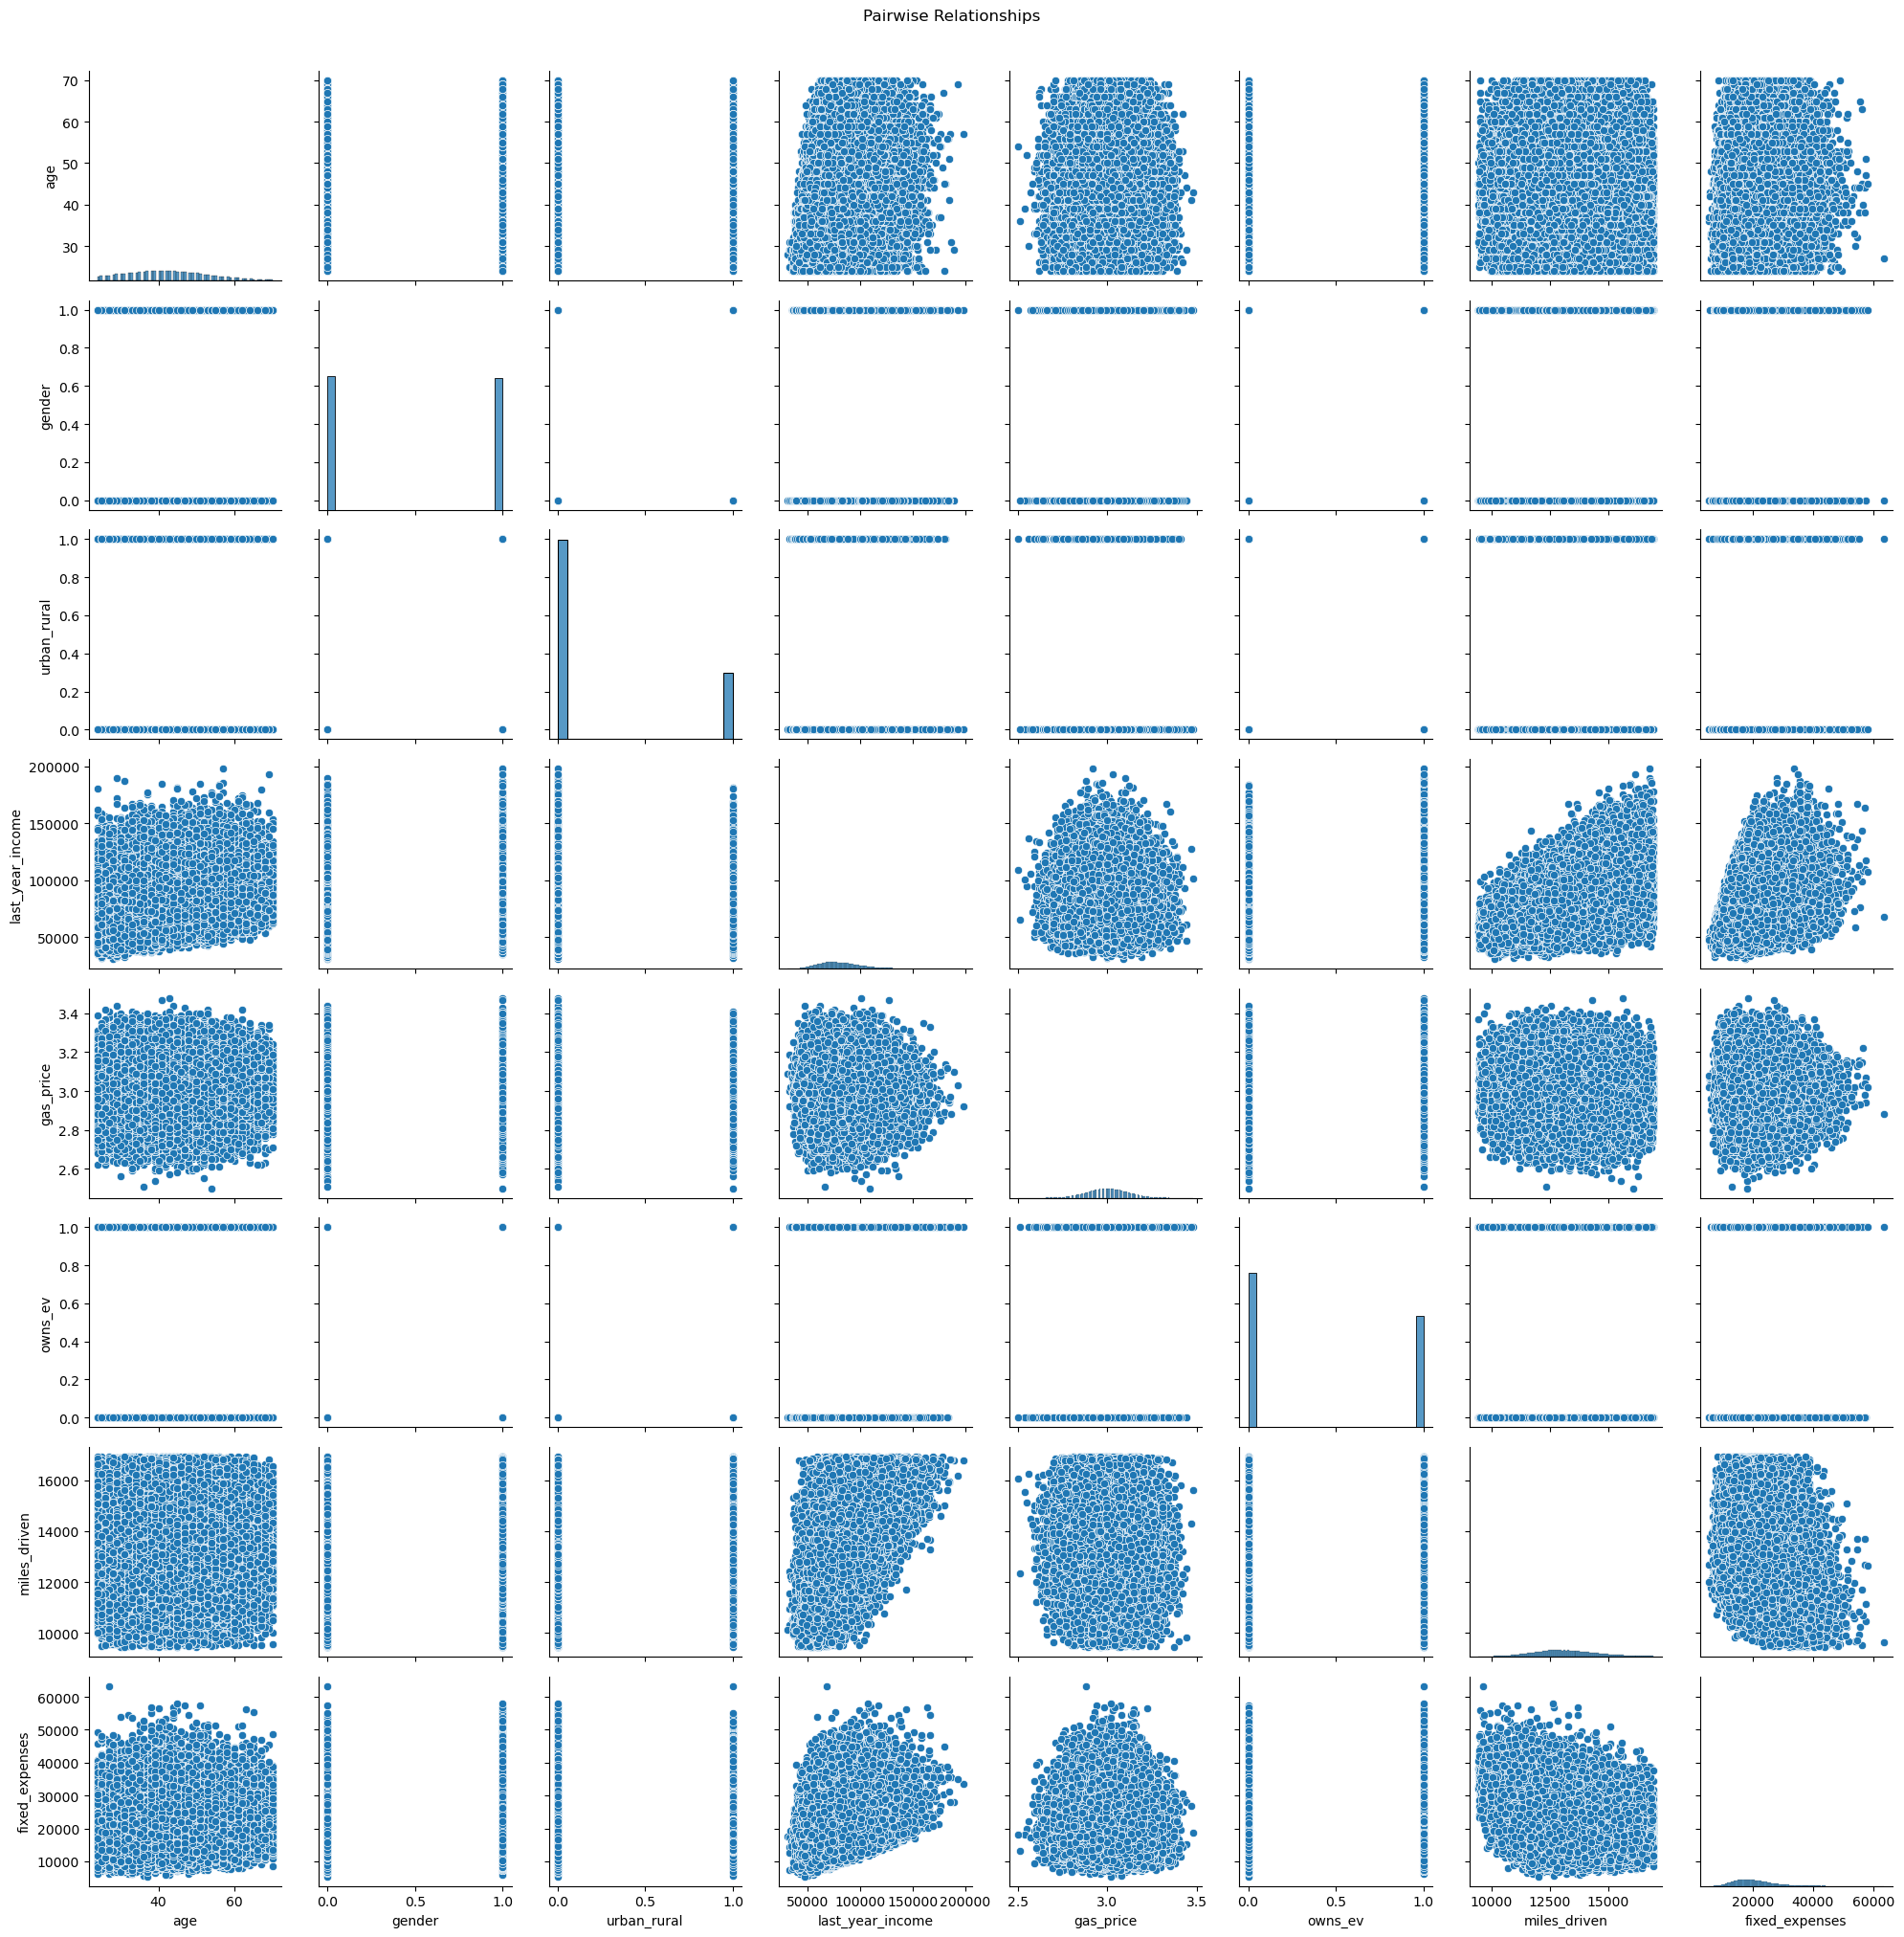

In [5]:
corr_matrix = data.corr()

# Heatmap of correlations
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

sns.pairplot(data)
plt.suptitle("Pairwise Relationships", y=1.01)
plt.tight_layout()
plt.show()

<br><br> Question 3

In [6]:
mean_difference = np.mean(data['miles_driven'][data['owns_ev'] == 1]) - np.mean(data['miles_driven'][data['owns_ev'] == 0])
mean_difference 

190.71781349717457

The mean difference is 190.72. This means that on average, owning an EV is associated with 190.72 more annual miles compared to not owning an ev. This difference probably does not reflect the average treatment effect of owning an EV on annual miles driven. There are likely several common causes of owning an EV and miles driven, for example gas prices, income, or age. 

<br><br> Question 4

I picked some arbitrary sets of variables

In [7]:
# All variables we can choose to add to the model
all_vars = ['age', 'gender', 'urban_rural', 'last_year_income', 'gas_price', 'fixed_expenses']

# Standardize non-binary variables for improved numerical stability
to_standardize = ['age', 'last_year_income', 'gas_price', 'fixed_expenses']

data_scaled = data.copy()
scaler = StandardScaler()
data_scaled[to_standardize] = scaler.fit_transform(data[to_standardize])

# Generate random adjustment sets
random.seed(3)

all_combos = []

for r in range(2, len(all_vars) + 1):
    combos = list(itertools.combinations(all_vars, r))
    all_combos.extend(combos)

# Shuffle and take 20 unique random ones
random.shuffle(all_combos)
selected_combos = all_combos[:20]

# Run regressions and print owns_ev coefficient
for i, adjustment_set in enumerate(selected_combos, 1):
    predictors = ['owns_ev'] + list(adjustment_set)
    X = data_scaled[predictors]
    y = data_scaled['miles_driven']

    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()

    coeff = model.params['owns_ev']
    std_err = model.bse['owns_ev']
    p_val = model.pvalues['owns_ev']

    print(f"\nmiles_driven ~ owns_ev + {', '.join(adjustment_set)}")
    print(f"owns_ev coefficient: {coeff:.4f} | Std Err: {std_err:.4f} | p-value: {p_val:.4f}")


miles_driven ~ owns_ev + urban_rural, gas_price, fixed_expenses
owns_ev coefficient: 296.0122 | Std Err: 8.7389 | p-value: 0.0000

miles_driven ~ owns_ev + gender, urban_rural, gas_price, fixed_expenses
owns_ev coefficient: 297.2670 | Std Err: 8.6078 | p-value: 0.0000

miles_driven ~ owns_ev + age, urban_rural, gas_price, fixed_expenses
owns_ev coefficient: 296.0858 | Std Err: 8.7351 | p-value: 0.0000

miles_driven ~ owns_ev + urban_rural, gas_price
owns_ev coefficient: 247.6860 | Std Err: 8.9443 | p-value: 0.0000

miles_driven ~ owns_ev + gender, last_year_income
owns_ev coefficient: -67.0465 | Std Err: 7.7449 | p-value: 0.0000

miles_driven ~ owns_ev + age, gas_price
owns_ev coefficient: 200.6857 | Std Err: 9.1371 | p-value: 0.0000

miles_driven ~ owns_ev + age, urban_rural, last_year_income
owns_ev coefficient: -32.1564 | Std Err: 7.5941 | p-value: 0.0000

miles_driven ~ owns_ev + age, urban_rural, gas_price
owns_ev coefficient: 247.5256 | Std Err: 8.9439 | p-value: 0.0000

miles_d

<br><br>In each regression, you can interpret the coefficient for $owns\_ev$ as "Holding all other variables in the model constant, owning an EV instead of a gasoline car is linearly associated with (coefficient) more annual miles, on average". You can clearly see that this coefficient varies widely among the different regressions, from negative values like -58 to positive values like 297. 

<br><br> Question 5

In [8]:
# Cross-validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=3)
results = []

# Evaluate each 4-variable combination
combos = list(itertools.combinations(all_vars, 4))

for combo in combos:
    predictors = ['owns_ev'] + list(combo)
    X = data_scaled[predictors].values
    y = data_scaled['miles_driven'].values

    mse_scores = []

    for train_idx, test_idx in kf.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model = LinearRegression()
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        mse = mean_squared_error(y_test, preds)
        mse_scores.append(mse)

    avg_mse = np.mean(mse_scores)
    results.append({
        'combo': combo,
        'avg_mse': avg_mse
    })

# Find the best model
best_model = min(results, key=lambda x: x['avg_mse'])

# Output
print("\nBest 4-variable adjustment set (with owns_ev):\n")
print("Combo:", best_model['combo'])
print("Average CV MSE:", round(best_model['avg_mse'], 2))


Best 4-variable adjustment set (with owns_ev):

Combo: ('gender', 'urban_rural', 'last_year_income', 'fixed_expenses')
Average CV MSE: 868677.37


In [9]:
# Use the best combo from previous step
optimal_combo = best_model['combo']
predictors = ['owns_ev'] + list(optimal_combo)

# Prepare X and y
X = data_scaled[predictors]
y = data_scaled['miles_driven']

# Add intercept
X = sm.add_constant(X)

# Fit the final model
final_model = sm.OLS(y, X).fit()

# Print summary
print("\nFinal Regression Model Summary (Best variable set in terms of MSE):\n")
print(f"Independent Variables: owns_ev, {', '.join(optimal_combo)}" + "\n")
print(final_model.summary())



Final Regression Model Summary (Best variable set in terms of MSE):

Independent Variables: owns_ev, gender, urban_rural, last_year_income, fixed_expenses

                            OLS Regression Results                            
Dep. Variable:           miles_driven   R-squared:                       0.525
Model:                            OLS   Adj. R-squared:                  0.525
Method:                 Least Squares   F-statistic:                 1.985e+04
Date:                Thu, 27 Mar 2025   Prob (F-statistic):               0.00
Time:                        13:58:23   Log-Likelihood:            -7.4193e+05
No. Observations:               89863   AIC:                         1.484e+06
Df Residuals:                   89857   BIC:                         1.484e+06
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t    

<br><br> We can interpret the coefficient for $owns\_ev$ in this model as follows: "For individuals with the same gender, living location (urban vs rural), last year's income and fixed expenses, owning an EV is linearly associated with 4.19 more annual miles compared to not owning an EV, on average"

<br><br> Question 6

In [10]:
# Cross-validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=3)
results = []

# Evaluate each 5-variable combination

combos = list(itertools.combinations(all_vars, 5))

for combo in combos:
    predictors = ['owns_ev'] + list(combo)
    X = data_scaled[predictors].values
    y = data_scaled['miles_driven'].values

    mse_scores = []

    for train_idx, test_idx in kf.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model = LinearRegression()
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        mse = mean_squared_error(y_test, preds)
        mse_scores.append(mse)

    avg_mse = np.mean(mse_scores)
    results.append({
        'combo': combo,
        'avg_mse': avg_mse
    })

# Find the best model
best_model = min(results, key=lambda x: x['avg_mse'])

# Output
print("\nBest 5-variable adjustment set (with owns_ev):\n")
print("Combo:", best_model['combo'])
print("Average CV MSE:", round(best_model['avg_mse'], 2))


Best 5-variable adjustment set (with owns_ev):

Combo: ('age', 'gender', 'urban_rural', 'last_year_income', 'fixed_expenses')
Average CV MSE: 844479.02


In [11]:
# Use the best combo from previous step
optimal_combo = best_model['combo']
predictors = ['owns_ev'] + list(optimal_combo)

# Prepare X and y
X = data_scaled[predictors]
y = data_scaled['miles_driven']

# Add intercept
X = sm.add_constant(X)

# Fit the final model
final_model = sm.OLS(y, X).fit()

# Print summary
print("\nFinal Regression Model Summary (Best variable set in terms of MSE):\n")
print(f"Independent Variables: owns_ev, {', '.join(optimal_combo)}" + "\n")
print(final_model.summary())



Final Regression Model Summary (Best variable set in terms of MSE):

Independent Variables: owns_ev, age, gender, urban_rural, last_year_income, fixed_expenses

                            OLS Regression Results                            
Dep. Variable:           miles_driven   R-squared:                       0.538
Model:                            OLS   Adj. R-squared:                  0.538
Method:                 Least Squares   F-statistic:                 1.745e+04
Date:                Thu, 27 Mar 2025   Prob (F-statistic):               0.00
Time:                        13:58:23   Log-Likelihood:            -7.4066e+05
No. Observations:               89863   AIC:                         1.481e+06
Df Residuals:                   89856   BIC:                         1.481e+06
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                       coef    std err          

<br><br> We can interpret the coefficient for $owns\_ev$ in this model as follows: "For individuals with the same gender, living location (urban vs rural), last year's income, fixed expenses and age, owning an EV is linearly associated with 8.08 less annual miles compared to not owning an EV, on average"

<br><br> Question 7

No, we can't. Linear regression coefficients are purely measures of association, and we have no idea whether these measured associations are biased or not (they likely are) or to which extent. And although the final models are optimal for predictive accuracy, this doesn't necessarily mean that they are also optimal for causal inference.